In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajin3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Load the data

data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
#Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
#Getting the record where 'verified_reviews' is null 

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
#We will drop the null record

data.dropna(inplace=True)


In [8]:
print(f"Dataset shape after dropping null values : {data.shape}")


Dataset shape after dropping null values : (3149, 5)


In [9]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [10]:
data.head()# you can see the length of the verified reviews here as given in the new column made by us

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
#Randomly checking for 10th record checking both that the len() function is working properly

print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


In [12]:
data.dtypes# show all the datatypes of all the columns which helps us to understand there data types properly

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

rating, feedback and length are integer values 
date, variation and verified_reviews are string values
### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [13]:
#Distinct values of 'rating' and its count  we can see that most of the ratings are for 5->2286

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


Let's plot the above values in a bar graph

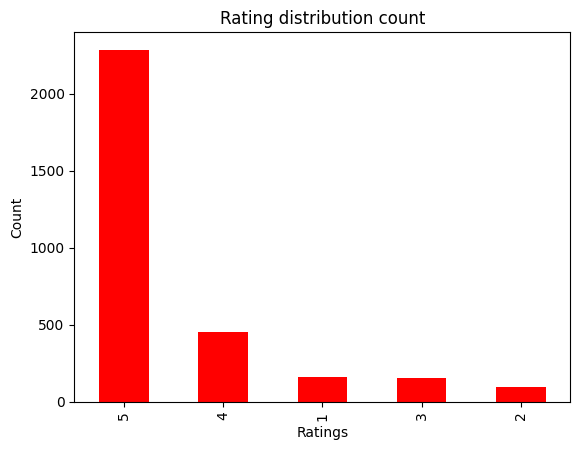

In [14]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [15]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


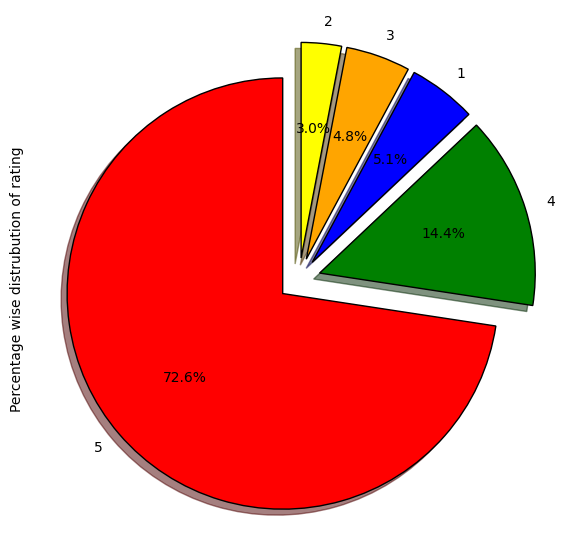

In [16]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [17]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

In [18]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [19]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

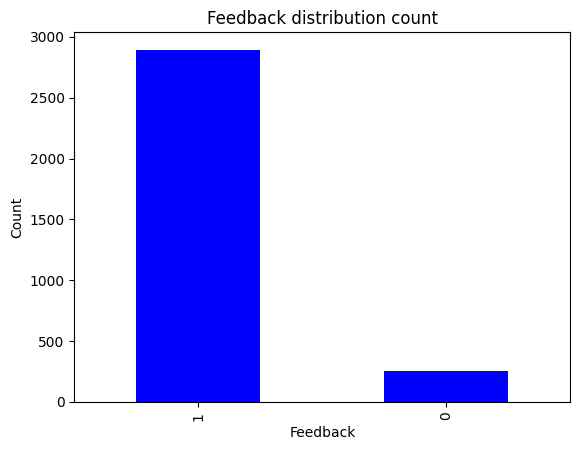

In [20]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [21]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

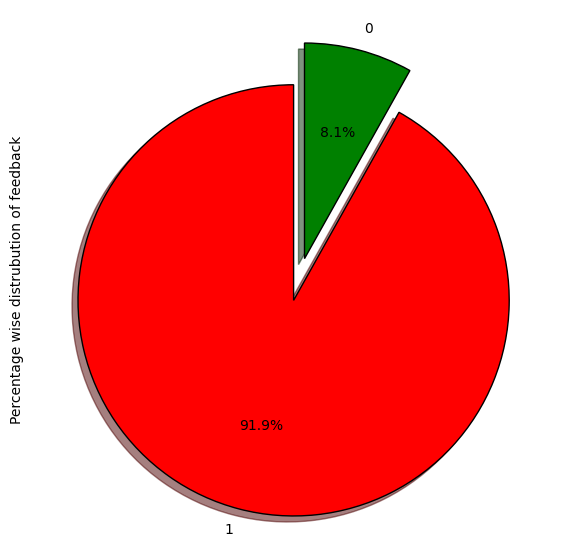

In [22]:
ig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [23]:
#Feedback = 0 pr negative will have rating 1,2
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [24]:
#Feedback = 1 or Positive will have rating from 3,4,5
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'variation' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [25]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


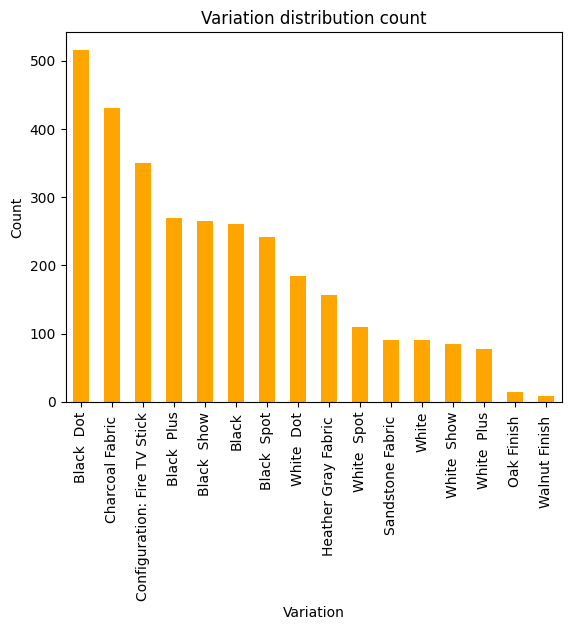

In [26]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [27]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [28]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

Let's analyze the above ratings

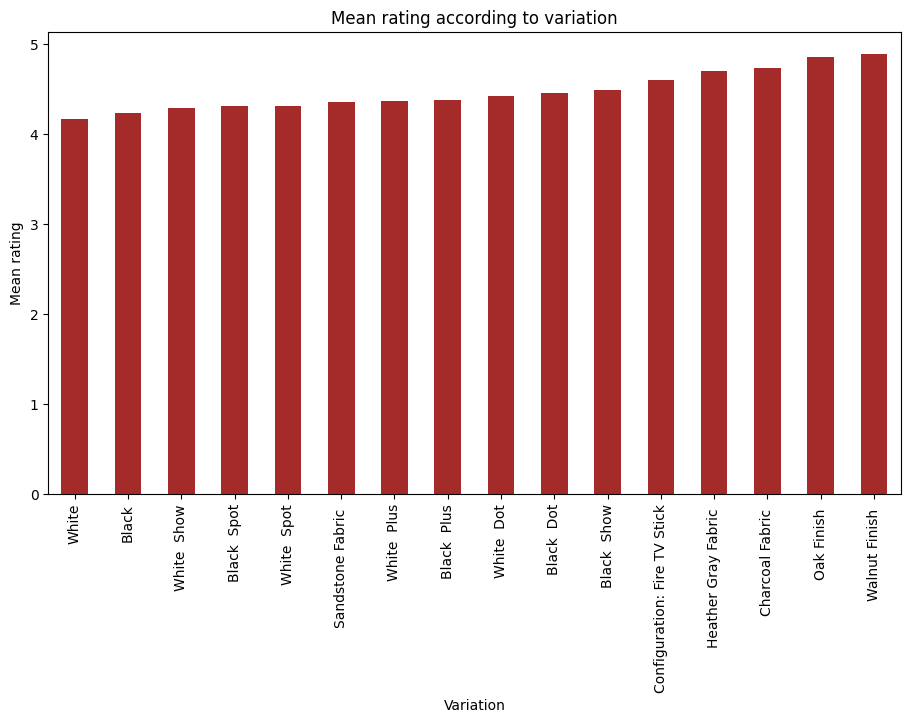

In [29]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [30]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

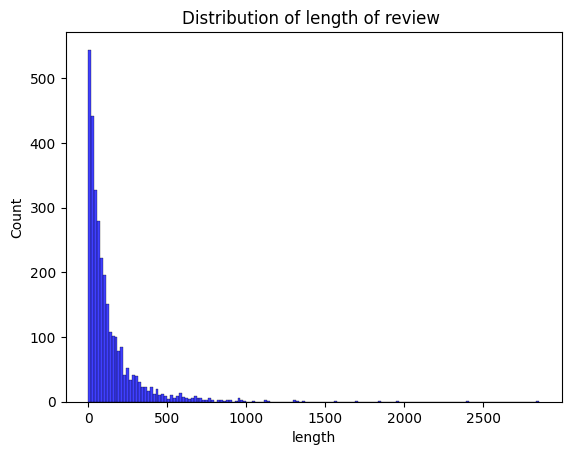

In [31]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

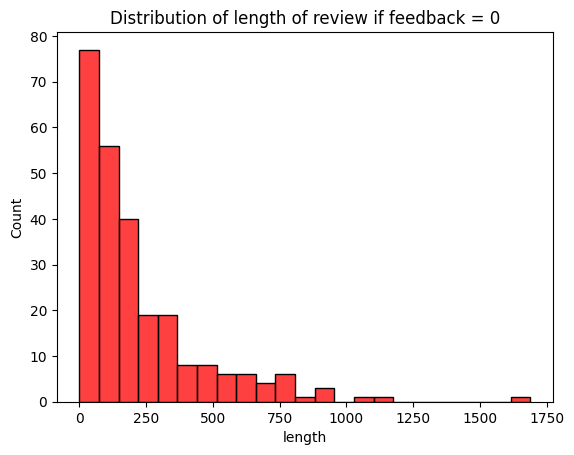

In [32]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

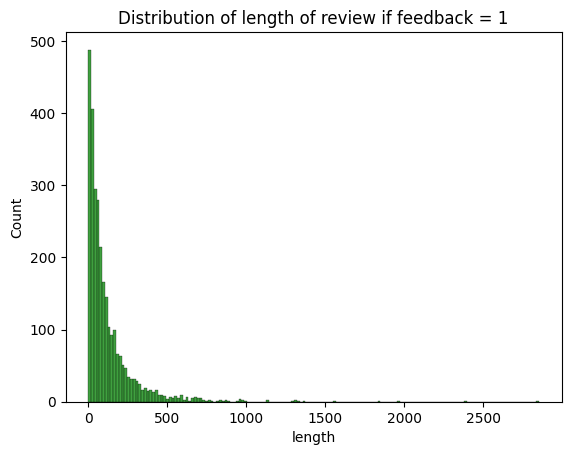

In [33]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

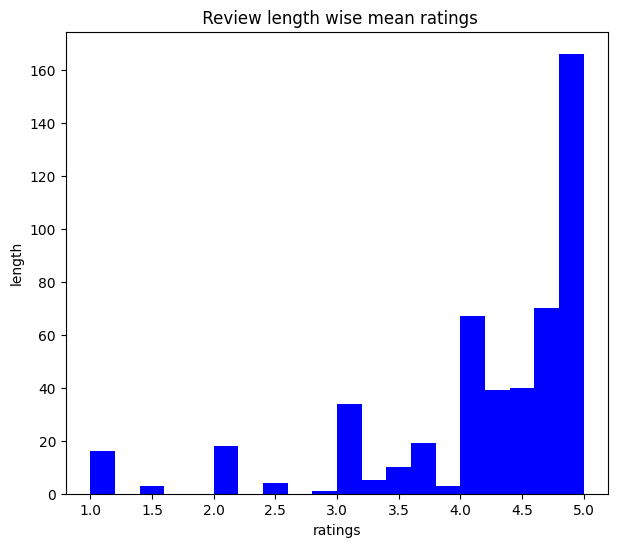

In [34]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [35]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

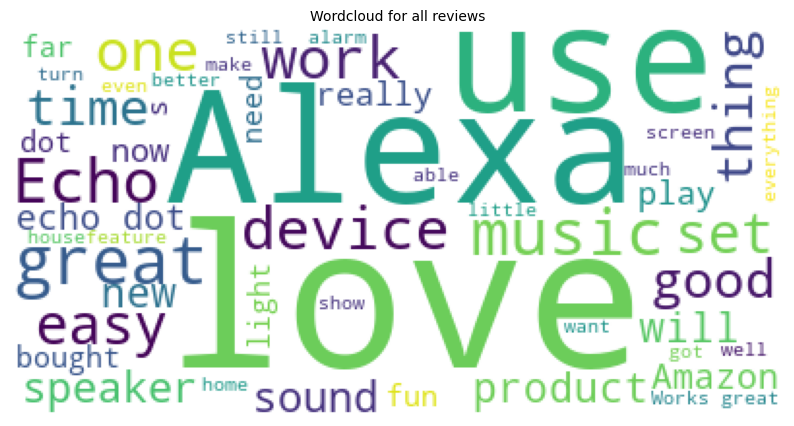

In [36]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [37]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


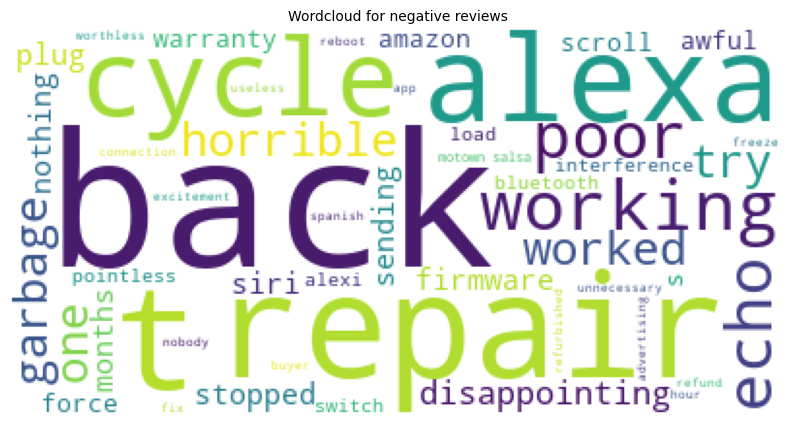

In [38]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

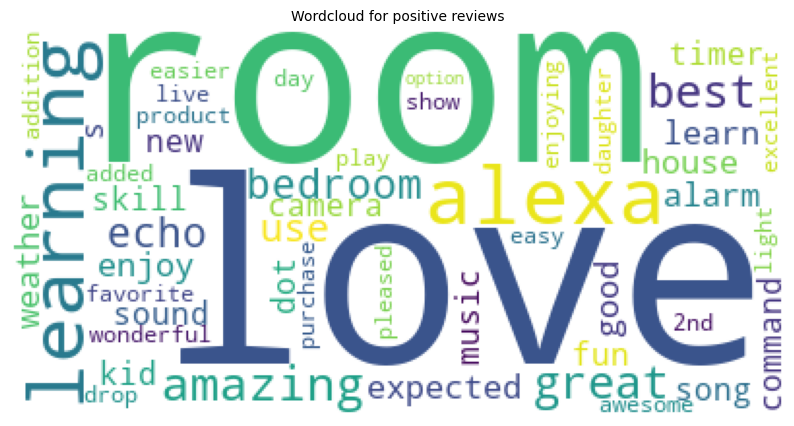

In [39]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajin3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ajin3\AppData\Roaming\nltk_data...



Evaluating Logistic Regression...
Logistic Regression Accuracy: 0.9174603174603174
              precision    recall  f1-score   support

    Negative       0.77      0.45      0.57        38
     Neutral       0.75      0.78      0.77        78
    Positive       0.95      0.97      0.96       514

    accuracy                           0.92       630
   macro avg       0.82      0.73      0.76       630
weighted avg       0.91      0.92      0.91       630



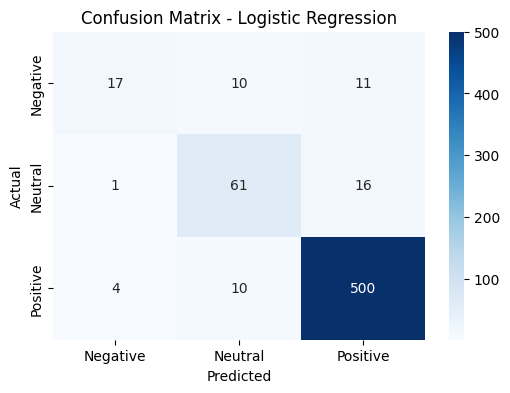


Evaluating Support Vector Machine...
Support Vector Machine Accuracy: 0.8777777777777778
              precision    recall  f1-score   support

    Negative       1.00      0.05      0.10        38
     Neutral       0.72      0.63      0.67        78
    Positive       0.90      0.98      0.93       514

    accuracy                           0.88       630
   macro avg       0.87      0.55      0.57       630
weighted avg       0.88      0.88      0.85       630



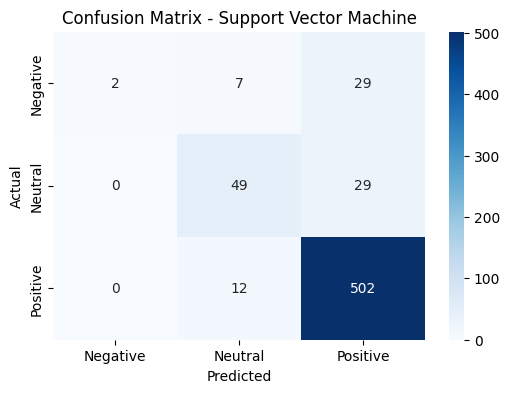


Evaluating Random Forest...
Random Forest Accuracy: 0.9142857142857143
              precision    recall  f1-score   support

    Negative       1.00      0.29      0.45        38
     Neutral       0.72      0.87      0.79        78
    Positive       0.95      0.97      0.96       514

    accuracy                           0.91       630
   macro avg       0.89      0.71      0.73       630
weighted avg       0.92      0.91      0.91       630



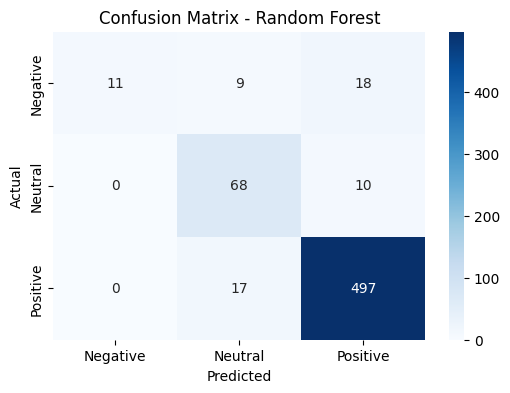


Evaluating Gradient Boosting...
Gradient Boosting Accuracy: 0.834920634920635
              precision    recall  f1-score   support

    Negative       0.78      0.18      0.30        38
     Neutral       0.89      0.10      0.18        78
    Positive       0.83      0.99      0.91       514

    accuracy                           0.83       630
   macro avg       0.83      0.43      0.46       630
weighted avg       0.84      0.83      0.78       630



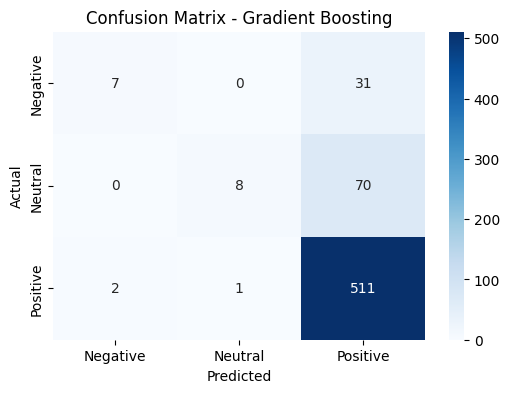

In [43]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK stopwords and VADER
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load the data
data = pd.read_csv('amazon_alexa.csv')

# Preprocessing Function
def preprocess_text(text):
    if isinstance(text, str):  # Check if input is a string
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.lower()  # Convert to lowercase
        text = " ".join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    else:
        text = ""  # Handle non-string values
    return text

# Clean up column names (if necessary)
data.columns = data.columns.str.strip()

# Handle missing values and keep only relevant columns
data = data.dropna(subset=['verified_reviews'])

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment based on VADER score
def classify_sentiment(review):
    score = analyzer.polarity_scores(review)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply preprocessing and sentiment analysis
data['cleaned_reviews'] = data['verified_reviews'].apply(preprocess_text)
data['sentiment'] = data['cleaned_reviews'].apply(classify_sentiment)

# Step 2: Feature Extraction
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X = vectorizer.fit_transform(data['cleaned_reviews'])

# Define labels
y = data['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model Training and Evaluation
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Print accuracy and classification report
    print(f"{model_name} Accuracy: {accuracy_score(y_test, predictions)}")
    print(classification_report(y_test, predictions))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Step 4: Choosing the Best Model
# Typically, Random Forest or Gradient Boosting are preferred because they capture complex relationships.
# Random Forest is often more interpretable and handles large datasets well.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajin3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Random Forest Accuracy: 0.9126984126984127
Classification Report - Random Forest:
               precision    recall  f1-score   support

    Negative       0.93      0.38      0.54        37
     Neutral       0.71      0.86      0.78        79
    Positive       0.95      0.96      0.95       514

    accuracy                           0.91       630
   macro avg       0.86      0.73      0.76       630
weighted avg       0.92      0.91      0.91       630



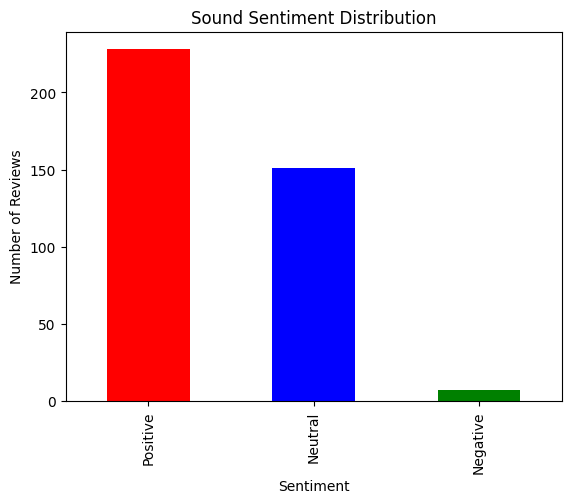

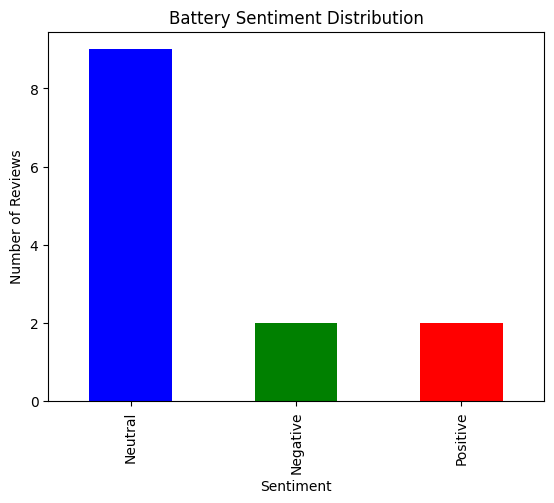

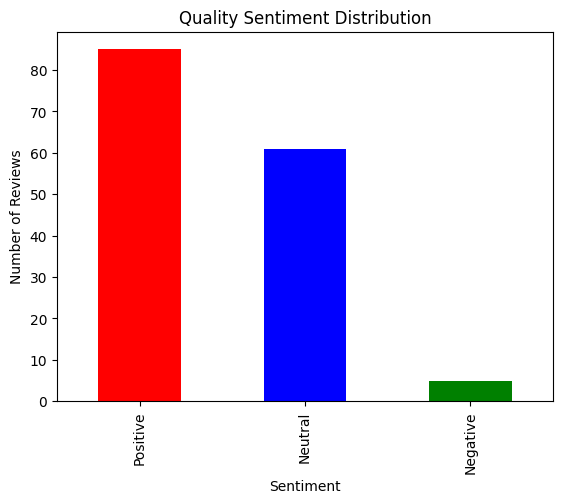

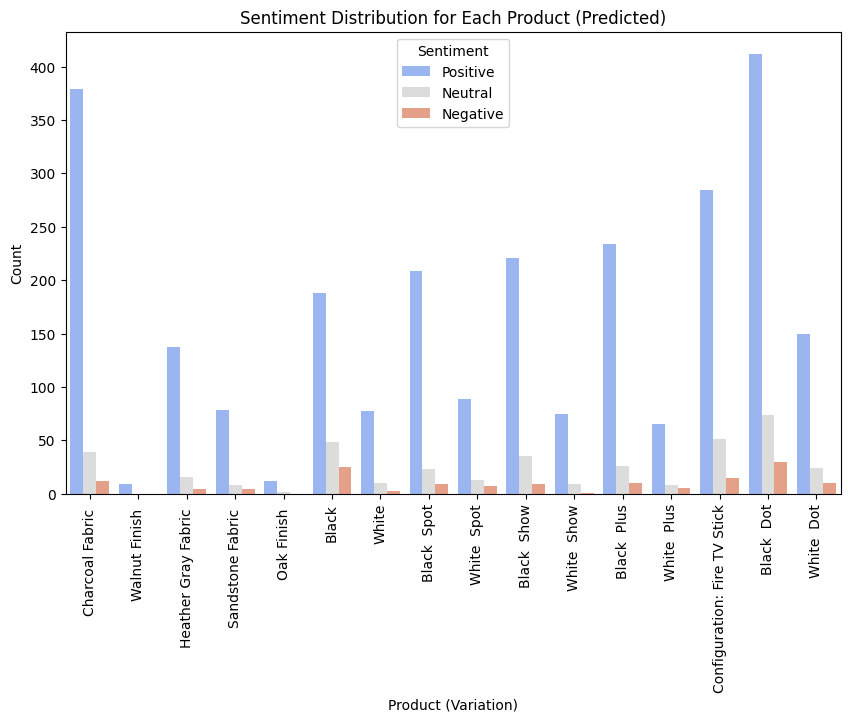

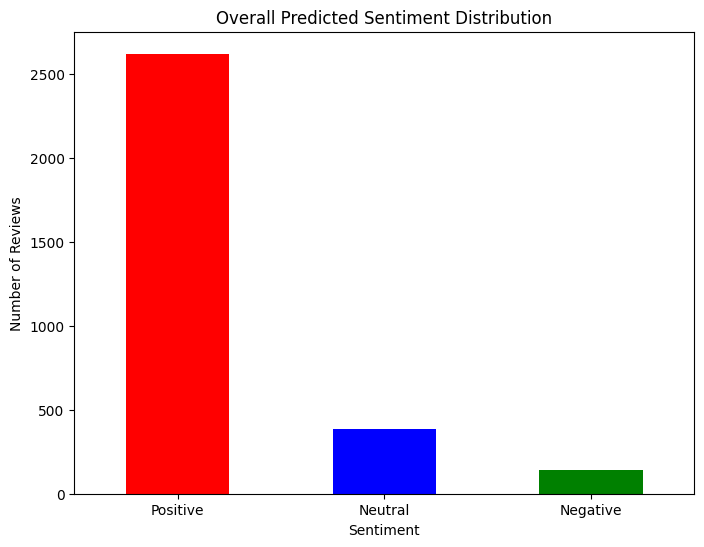

In [44]:
# Importing necessary libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK stopwords
nltk.download('stopwords')

# Load the data
data = pd.read_csv('amazon_alexa.csv')

# Step 1: Data Preprocessing
def preprocess_text(text):
    if isinstance(text, str):  # Check if input is a string
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.lower()  # Convert to lowercase
        text = " ".join([word for word in text.split() if word not in stopwords.words('english')])  # Remove stopwords
    else:
        text = ""  # Handle non-string values
    return text

# Clean up column names (if necessary)
data.columns = data.columns.str.strip()

# Handle missing values and only keep relevant columns
data = data.dropna(subset=['verified_reviews'])

# Step 2: Sentiment Analysis using VADER
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment based on VADER score
def classify_sentiment(review):
    score = analyzer.polarity_scores(review)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply preprocessing and sentiment analysis
data['cleaned_reviews'] = data['verified_reviews'].apply(preprocess_text)
data['sentiment'] = data['cleaned_reviews'].apply(classify_sentiment)

# Step 3: Aspect-Based Sentiment Analysis
# Identify the aspects (e.g., sound, battery life, quality)
aspects = ['sound', 'battery', 'quality']

# Define a function to extract aspect-based sentiment
def extract_aspect_sentiment(text, aspect):
    if pd.isna(text):  # Check if the text is missing (NaN)
        return None  # Return None for missing values
    # Use a rule-based approach to extract sentiment towards the aspect
    if aspect in text.lower():
        if 'good' in text.lower() or 'great' in text.lower():
            return 1  # Positive sentiment
        elif 'bad' in text.lower() or 'poor' in text.lower():
            return 0  # Negative sentiment
        else:
            return 0.5  # Neutral sentiment
    else:
        return None  # Aspect not mentioned

# Create a new column for each aspect with the extracted sentiment
for aspect in aspects:
    data[aspect] = data['verified_reviews'].apply(lambda x: extract_aspect_sentiment(x, aspect))

# Step 4: Feature Extraction (using CountVectorizer)
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X = vectorizer.fit_transform(data['cleaned_reviews'])

# Create target variable 'y' based on sentiment
y = data['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Model Training and Evaluation (Random Forest)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Predictions and Evaluation
rf_predictions = rf_model.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report - Random Forest:\n", classification_report(y_test, rf_predictions))

# Step 7: Visualization of Aspect-Based Sentiment Distribution
# Map numerical sentiment values to labels for visualization
sentiment_mapping = {1: 'Positive', 0.5: 'Neutral', 0: 'Negative'}
color_mapping = {'Positive': 'red', 'Neutral': 'blue', 'Negative': 'green'}

# Visualize the aspect-based sentiment distribution with specified colors
for aspect in aspects:
    sentiment_counts = data[aspect].map(sentiment_mapping).value_counts()
    sentiment_counts.plot(kind='bar', color=[color_mapping.get(sentiment) for sentiment in sentiment_counts.index])
    plt.title(f'{aspect.capitalize()} Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Reviews')
    plt.show()

# Step 8: Visualization of Sentiment Distribution for Each Product (Overall)
# Use the Random Forest model to predict sentiments for the entire dataset
data['predicted_sentiment'] = rf_model.predict(X)

# Visualizing sentiment for each product (variation)
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='variation', hue='predicted_sentiment', palette='coolwarm')
plt.title('Sentiment Distribution for Each Product (Predicted)')
plt.xticks(rotation=90)
plt.xlabel('Product (Variation)')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Step 9: Overall sentiment distribution
plt.figure(figsize=(8, 6))
predicted_sentiment_counts = data['predicted_sentiment'].value_counts()
predicted_sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Overall Predicted Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()
